# Top

In [1]:
import torch
import torchinfo
import torchvision
import torch.nn.functional as F

from torch import nn
from torchvision import transforms
from torch.cuda.amp import autocast,GradScaler
from torchvision.models.resnet import BasicBlock
from tensorboardX import SummaryWriter

In [2]:
import os
import cv2
import PIL
import time
import numpy as np
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from typing import Tuple,List,Dict
from xml.etree import cElementTree as etree

In [3]:
class yolov1_resnet(nn.Module):
    
    def __init__(self, layer:int):
        super(yolov1_resnet,self).__init__()
        if layer == 18:
            self.backbone = torchvision.models.resnet18(pretrained=True)
        elif layer == 34:
            self.backbone = torchvision.models.resnet34(pretrained=True)
        elif layer == 50:
            self.backbone = torchvision.models.resnet50(pretrained=True)
        else:
            raise NotImplementedError
            
        self.backbone.fc = nn.Identity()
        
        # as paper suggested, deeper conv layer
        in_ch = 512 if layer != 50 else 2048
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch,1024,3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024,1024,3,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024,1024,3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024,1024,3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
        )
        
#         self.conv = self.backbone._make_layer(BasicBlock, 1024, 2, stride=2)
                
        # too much parameters, over one fourth billion
#         self.classifier = nn.Sequential(
#             nn.Linear(7*7*512,1024),
#             nn.Dropout(p=.5),
#             nn.LeakyReLU(0.1),
#             nn.Linear(1024,7*7*30),
#         )

        self.conv_out = nn.Sequential(
            nn.Conv2d(1024,30,(1,1),stride=1)
        )

        
    def forward(self,x):
        tmp = self.backbone.conv1(x)
        tmp = self.backbone.bn1(tmp)
        tmp = self.backbone.relu(tmp)
        tmp = self.backbone.maxpool(tmp)
        tmp = self.backbone.layer1(tmp)
        tmp = self.backbone.layer2(tmp)
        tmp = self.backbone.layer3(tmp)
        tmp = self.backbone.layer4(tmp)
        
        tmp = self.conv(tmp)
        tmp = self.conv_out(tmp)
        
#         tmp = torch.flatten(tmp,start_dim=1)
#         tmp = self.classifier(tmp)
#         tmp = tmp.reshape(-1,30,7,7)#.contiguous()
        
        return tmp

In [ ]:
torchinfo.summary(yolov1(), input_size=(64, 3, 448, 448))

In [23]:
#模型測試
torch.testing.assert_equal(yolov1_resnet(18)(torch.randn(1,3,448,448)).shape,torch.Size([1, 30, 7, 7]))
torch.testing.assert_equal(yolov1_resnet(34)(torch.randn(1,3,448,448)).shape,torch.Size([1, 30, 7, 7]))
torch.testing.assert_equal(yolov1_resnet(50)(torch.randn(1,3,448,448)).shape,torch.Size([1, 30, 7, 7]))

# Loss

In [4]:
def generate_grid_train(grid_size: Tuple[int, int]) -> torch.Tensor:
    # recover x,y coord since we use x,y offset
    grid_x, grid_y = grid_size
    y_offset, x_offset = torch.meshgrid(torch.arange(grid_x),torch.arange(grid_y))    
    
    grid_tmp = torch.cat([x_offset.unsqueeze(0),y_offset.unsqueeze(0)],dim=0) # 2, 7, 7

    grid_tmp = grid_tmp.unsqueeze(0)/grid_size[0] # 1, 2, 7 ,7 # to relative
    
    return grid_tmp

In [5]:
def xywh_to_xyxy(coord: torch.Tensor) -> torch.Tensor:
    # convert xywh to xyxy
    b, _, sx, sy = coord.shape
    d = 'cuda:0' if coord.is_cuda else 'cpu'
    grid_for_train = generate_grid_train((sx,sy)).repeat(b,1,1,1).to(d) 
    xy = coord[:,0:2,:,:]+grid_for_train # B, 2, 7, 7
    wh = coord[:,2:4,:,:] # B, 2, 7, 7 

    return torch.cat([xy-wh/2,xy+wh/2],dim=1) # B, 4, 7, 7

In [6]:
def IOU(cbox1: torch.Tensor, cbox2: torch.Tensor) -> torch.Tensor:
    """
    input: x_offset y_offset wh format
    output: iou for each batch and grid cell
    """
        
    # coord_conversion
#     cbox1[:,2:4,:,:] = cbox1[:,2:4,:,:].pow(2)
    box1 = xywh_to_xyxy(cbox1) # B, 4, 7, 7
    box2 = xywh_to_xyxy(cbox2)
    
    # find intersection
    x1 = torch.max(box1[:,0:1,:,:],box2[:,0:1,:,:])
    y1 = torch.max(box1[:,1:2,:,:],box2[:,1:2,:,:])
    x2 = torch.min(box1[:,2:3,:,:],box2[:,2:3,:,:])
    y2 = torch.min(box1[:,3:4,:,:],box2[:,3:4,:,:])
    
    intersection = (x2-x1).clamp(min=0) * (y2-y1).clamp(min=0) # N, 1, 7, 7
    
    total_area = abs(cbox1[:,2:3,:,:] * cbox1[:,3:4,:,:]) + cbox2[:,2:3,:,:]*cbox2[:,3:4,:,:] - intersection # N, 1, 7, 7

    intersection[intersection.gt(0)] = intersection[intersection.gt(0)] / total_area[intersection.gt(0)]
    
#     intersection.clamp_(min = 0, max = 1) #TODO: check if clamp and abs prediction area necessary
    
    return intersection

In [7]:
def RMSE(cbox1: torch.Tensor, cbox2: torch.Tensor) -> torch.Tensor:
    with torch.no_grad():
        cbox1[:,2:4,:,:] = cbox1[:,2:4,:,:]
        cbox2[:,2:4,:,:] = cbox2[:,2:4,:,:].sqrt()
    return F.mse_loss(cbox1,cbox2, reduction='none')

In [8]:
class YoloLoss(nn.Module):
    
    def __init__(self, lambda_coord = 5, lambda_noobject = 0.5):
        super(YoloLoss,self).__init__()
        
        self.grid_size = IMAGE_SIZE//64
        self.lambda_coord = lambda_coord
        self.lambda_noobject = lambda_noobject
        self.epsilon = 1e-5
        
    def positive_box(self, prediction: torch.Tensor, groundtruth: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        with torch.no_grad():
            ious = [IOU(prediction[:,(1+5*b):(5+5*b),:,:], groundtruth[:,1:5,:,:]) for b in range(NUM_BOXES)]
#             rmse = [RMSE(prediction[:,(1+5*b):(5+5*b),:,:], groundtruth[:,1:5,:,:]) for b in range(NUM_BOXES)]
        ious = torch.cat(ious, dim=1) # N, 2, 7, 7
#         rmse = torch.cat(rmse, dim=1)
        
        max_iou, best_box = ious.max(dim=1,keepdim=True) # N,1,7,7
        best_box = torch.stack([best_box.eq(b).int() for b in range(NUM_BOXES)], 1) # N, 2, 1, 7, 7
        max_iou = torch.stack([max_iou for b in range(NUM_BOXES)], 1) # N, 2, 1, 7, 7
        
#         min_rmse, alt_box = rmse.min(dim=1,keepdim=True)
#         alt_box = torch.stack([alt_box.eq(b).int() for b in range(NUM_BOXES)], 1) # N, 2, 1, 7, 7
#         min_rmse = torch.stack([min_rmse for b in range(NUM_BOXES)], 1) # N, 2, 1, 7, 7
        
#         best_box[max_iou.le(0).logical_and(min_rmse.lt(20))] = alt_box[max_iou.le(0).logical_and(min_rmse.lt(20))]
        
        return max_iou, best_box
    
    def build_target(self, groundtruth: List[tuple]) -> torch.Tensor:        
        label = torch.zeros((5+NUM_CLASSES, self.grid_size, self.grid_size))
                
        for g in groundtruth:
            cx, cy, w, h, c = g
            c = int(c)
            x = (cx % (1/self.grid_size)) # left offset
            y = (cy % (1/self.grid_size)) # top offset
        
            x_ind = int(cx*self.grid_size)
            y_ind = int(cy*self.grid_size)
            label[0,y_ind,x_ind] = 1
            label[1:5,y_ind,x_ind] = torch.Tensor([x,y,w,h])
            label[5+c,y_ind,x_ind] = 1
        
        return label
        
    def forward(self, prediction: torch.Tensor, groundtruth: list) -> torch.Tensor:
        b, _, grid_y, grid_x = prediction.shape
        groundtruth = torch.stack([self.build_target(g) for g in groundtruth],0).float().to(DEVICE)
        
        # iou indicator
        ious, best_box = self.positive_box(prediction, groundtruth) # N, 2, 1, 7, 7
        
        # predictions
        box_pred = prediction[:,:5*NUM_BOXES,:,:].reshape(b, NUM_BOXES, 5, grid_y, grid_x) # N, 2, 5, 7, 7
        xy_pred = box_pred[:,:,1:3,:,:]
#         wh_pred = box_pred[:,:,3:5,:,:]
        wh_pred = box_pred[:,:,3:5,:,:].sign() * (box_pred[:,:,3:5,:,:].abs()+self.epsilon).sqrt() # sqrt the value then plus sign back
        
        cls_pred = prediction[:,NUM_BOXES*5:,:,:] # N, 20, 7, 7
    
        # groundtruth
        box_truth = groundtruth[:,1:5,:,:].unsqueeze(1).tile(1,NUM_BOXES,1,1,1)
        box_truth[:,:,2:4,:,:] = box_truth[:,:,2:4,:,:].sqrt() # N, 2, 4, 7, 7
    
        # obj indicator
        obj_here = groundtruth[:,0:1,:,:] # N,1,7,7
        box_here = obj_here.unsqueeze(1) # N, 1, 1, 7, 7
        positive = box_here * best_box
        
        # class loss objecness loss and xywh loss                
        # indicator has to be inside the loss function
        cls_loss = F.mse_loss(obj_here * cls_pred, groundtruth[:,5:,:,:],reduction="sum")
        xy_loss = F.mse_loss(positive * xy_pred, positive * box_truth[:,:,0:2,:,:],reduction="sum")
        wh_loss = F.mse_loss(positive * wh_pred, positive * box_truth[:,:,2:4,:,:],reduction="sum")
        obj_loss = F.mse_loss(positive * box_pred[:,:,0:1,:,:], positive * ious,reduction="sum")
        noobj_loss = F.mse_loss((1 - positive) * box_pred[:,:,0:1,:,:], ious*0, reduction="sum")    
        
        total_loss = cls_loss + self.lambda_noobject * noobj_loss + obj_loss + self.lambda_coord * (xy_loss+wh_loss)

        return total_loss

In [9]:
class VOC_dataset(torch.utils.data.Dataset):
    
    def __init__(self, root, year='2012', mode='train', transform=None):
        list_path = [(os.path.join(root,f'VOCdevkit/VOC{y}/ImageSets/Main/{mode}.txt'),y) for y in year.split('+')]

        self.root = root
        self.year = year
        self.mode = mode
        self.transform = transform
        self.labels = []
        for p,y in list_path:
            with open(p,'r') as f:
                p = [os.path.join(root,f'VOCdevkit/VOC{y}/Annotations',f'{g.strip()}.xml') for g in f.readlines()]
                self.labels += p

            
    def __len__(self):
        return len(self.labels)

    
    def get_img(self, idx):
        jpg = self.labels[idx].replace('Annotations','JPEGImages').replace('xml','jpg')
            
        img = cv2.imread(jpg)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape
        
        return img,h,w
    
    def get_label(self,idx,h,w):
        xml = self.labels[idx]
        tree = etree.parse(xml)
        label = self.process_label(tree,h,w)
        
        return label

    def __getitem__(self, idx):        
        img,h,w = self.get_img(idx)
        label = self.get_label(idx,h,w) #if self.mode != 'test' else None
        
        if self.transform: 
            transformed_data = self.transform(image=img,bboxes=label)
            img = transformed_data['image']
            label = transformed_data['bboxes'] # totensor
        
        return img, label
    
    def process_label(self,tree,img_h,img_w):
        tree = tree.findall('object')
                
        label = []

        for obj in tree:
            if obj.find('difficult').text == '1': 
                continue
            bbox = obj.find('bndbox')

            xmin = float(bbox.find('xmin').text)
            xmax = float(bbox.find('xmax').text)
            ymin = float(bbox.find('ymin').text)
            ymax = float(bbox.find('ymax').text)

            w = (xmax-xmin)/img_w
            h = (ymax-ymin)/img_h

            class_ind = voc_classes.index(obj.find('name').text)

            cx = (xmin+xmax)/2/img_w
            cy = (ymin+ymax)/2/img_h
            
            label.append([cx,cy,w,h,class_ind])
                                
        return label

In [10]:
def collate_fn(batch):
    img_list = []
    label_list = []
    
    for a,b in batch:
        img_list.append(a)
        label_list.append(b)
        
    return torch.stack(img_list,0), label_list

# setting

In [11]:
torch.backends.cudnn.benchmark=True

In [12]:
voc_classes = ["aeroplane", "bicycle", "bird", "boat", "bottle",
            "bus", "car", "cat", "chair", "cow", "diningtable",
            "dog", "horse", "motorbike", "person", "pottedplant",
            "sheep", "sofa", "train", "tvmonitor"]

In [13]:
MODEL_BACKBONE = 'resnet34'

if MODEL_BACKBONE == 'yolov1':
    BATCH_SIZE = 64
    ACC_ITER = 1
elif MODEL_BACKBONE == 'resnet18':
    BATCH_SIZE = 32
    ACC_ITER = 2
elif MODEL_BACKBONE == 'resnet34':
    BATCH_SIZE = 16
    ACC_ITER = 4
elif MODEL_BACKBONE == 'resnet50':
    BATCH_SIZE = 8
    ACC_ITER = 8
    
IMAGE_SIZE = 448
DEVICE = 'cuda:0'
NUM_BOXES = 2
NUM_CLASSES = len(voc_classes)
LR = 1e-4
DECAY = 5e-4

In [14]:
preprocess_train = A.Compose([
    A.Resize(IMAGE_SIZE,IMAGE_SIZE),
    A.ColorJitter(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5, rotate_limit= 0),
    A.Normalize(mean=(0,0,0),std=(1,1,1)),
    ToTensorV2(),
],bbox_params=A.BboxParams(format='yolo',min_area=1024,min_visibility=0.3))

In [15]:
preprocess_val = A.Compose([
    A.Resize(IMAGE_SIZE,IMAGE_SIZE),
    A.Normalize(mean=(0,0,0),std=(1,1,1)),
    ToTensorV2(),
])

In [16]:
trainset = VOC_dataset('../data', year='2012+2007', mode='trainval', transform=preprocess_train)
testset = VOC_dataset('../data', year='2007', mode='test', transform=preprocess_val)

In [17]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_fn)
testloader = torch.utils.data.DataLoader(testset,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn)

In [18]:
if MODEL_BACKBONE.startswith('resnet'):
    layer_num = int(MODEL_BACKBONE[6:])
    model = yolov1_resnet(layer_num).to(DEVICE)
elif MODEL_BACKBONE == 'yolov1':
    model = yolov1().to(DEVICE)

In [19]:
criterion = YoloLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=LR,weight_decay=DECAY)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,lr_lambda=[lambda e: 1e-4 if e < 50 else 5e-5])

In [20]:
writer = SummaryWriter()

# training

In [21]:
def train(e):
    model.train()
    optimizer.zero_grad(set_to_none=True)
    for i, data in enumerate(tqdm(trainloader)):

        img, label = data
        
        img= img.to(DEVICE) 

        output = model(img)
        loss = criterion(output,label)
        loss = loss/ACC_ITER
        
        loss.backward()
        
        if i % ACC_ITER == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        
        assert not np.isnan(loss.item()), 'loss died'
        
        writer.add_scalar(f'training loss', loss.item(), i+e*len(trainloader),
                         summary_description=f'{MODEL_BACKBONE}/{LR}/final')

    
    if (e+1) % 10 == 0:
        torch.save(model.state_dict(),f'yolov1.{MODEL_BACKBONE}.{e+1}.pth')
    
#     val_loss = validate(e)
#     scheduler.step(val_loss)

In [22]:
def validate(e):
    model.eval()
    val_loss = 0
    print('validating......')
    with torch.no_grad():
        for i, data in enumerate(tqdm(testloader)):

            img, label = data

            img= img.to(DEVICE) 
            label = label.to(DEVICE) 

            output = model(img)
            loss = criterion(output,label)
            val_loss += loss.item()

            assert not np.isnan(val_loss), 'loss died'

    writer.add_scalar(f'validation loss', val_loss/len(testset), e,
                      summary_description=f'{MODEL_BACKBONE}/{LR}/plateau')
    return val_loss/len(testset)

In [23]:
epoches = 150
for epoch in range(0,epoches):
    train(epoch)

  0%|                                                                                         | 0/1035 [00:00<?, ?it/s]C:\Users\User\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████████████████████████████████████████████████████████████████████████| 1035/1035 [05:55<00:00,  2.91it/s]


In [24]:
writer.close()

# load

In [20]:
# load carefully, if you have many checkpoints
model.load_state_dict(torch.load(f'yolov1.{MODEL_BACKBONE}.100.pth'))

<All keys matched successfully>

# decode

In [25]:
def generate_grid(grid_size: Tuple[int]) -> torch.Tensor:
    grid_x, grid_y = grid_size
    y_offset, x_offset = torch.meshgrid(torch.arange(grid_x),torch.arange(grid_y))
    
    return x_offset, y_offset

In [26]:
def yolov1_decode(featuremap: torch.Tensor, model_image_size: Tuple[int, int], num_classes: int, num_anchors: int) -> torch.Tensor:
    
    batch_size, channel_size, fm_h, fm_w = featuremap.shape
    input_h, input_w = model_image_size
    stride_x, stride_y = input_w/fm_w, input_h/fm_h
    num_bbox = int((channel_size - num_classes)/5)
    
    grid_x, grid_y = generate_grid((fm_w,fm_h))

    bbox_info = []
    for b in range(num_bbox):
        # batch_size, 1, grid_size x grid_size
        cx = (featuremap[:,(1+5*b):(2+5*b),:,:]*input_w+grid_x*stride_x).reshape(batch_size,1,-1) 
        cy = (featuremap[:,(2+5*b):(3+5*b),:,:]*input_h+grid_y*stride_y).reshape(batch_size,1,-1)
        w = (featuremap[:,(3+5*b):(4+5*b),:,:]*input_w).reshape(batch_size,1,-1) 
        h = (featuremap[:,(4+5*b):(5+5*b),:,:]*input_h).reshape(batch_size,1,-1)
        conf = featuremap[:,0+5*b,:,:].reshape(batch_size,1,-1)
        prob = featuremap[:,5*num_bbox:,:,:].reshape(batch_size,num_classes,-1)
        x = cx - w/2
        y = cy - h/2
                
        bbox_info.append(torch.cat([x,y,w,h,conf,prob],1))
        
    result = torch.cat(bbox_info,-1).transpose(1,2)

    return result

# visualization

In [27]:
def draw_pred(img:np.ndarray, bboxes: torch.Tensor, class_show:bool):
    """draw predicted bbox"""
    
    for b in bboxes:
        x, y, w, h, c = b[:5]
        x, y, w, h = int(x), int(y), int(w), int(h)
        prob, cls_index = b[5:].max(0)
        if prob > conf_thres:
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2)

            if class_show:
                cv2.rectangle(img,(x,y-30),(x+w,y),(0,0,255),-1)
                cv2.putText(img,voc_classes[cls_index.item()],(x+5,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),1)

In [28]:
# labels
def draw_label(img:np.ndarray, label: torch.Tensor):
    """draw detection label"""
    
#     label[:5,:].reshape(5,-1).transpose(1,0)
    for i, (x,y,w,h,c) in enumerate(label):
#         grid_x, grid_y = i%7, i//7
#         cx, cy = grid_x*64+int(x*IMAGE_SIZE), grid_y*64+int(y*IMAGE_SIZE)
#         w, h = int(w*IMAGE_SIZE) , int(h*IMAGE_SIZE)
#         x, y = int(cx-w/2), int(cy-h/2)
        x,y,w,h = x*IMAGE_SIZE, y*IMAGE_SIZE, w*IMAGE_SIZE, h*IMAGE_SIZE
        x1, y1, x2, y2 = int(x-w/2), int(y-h/2), int(x+w/2), int(y+h/2),
        cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),2)

In [29]:
def model_predict(img: torch.Tensor) -> torch.Tensor:
    
    with torch.no_grad():
        img = img.unsqueeze(0).to(DEVICE) if img.dim() == 3 else img.to(DEVICE)
        model.eval()
        pred = model(img)

        pred = pred.detach().cpu()
        img = img.detach().cpu()
    
    return pred

In [30]:
def nms(bbox: torch.Tensor, score: torch.Tensor, nms_thres: float, conf_thres: float) -> list:
    c_sort, sort_index = score.sort(descending=True)
    tmp_bbox = bbox[sort_index]

    best_index = []
    remove_index = []
    for i, (b,c) in enumerate(zip(tmp_bbox,c_sort)):
        if i==len(tmp_bbox)-1: break
        if i in remove_index: continue
        if conf_thres > c: continue
        x,y,w,h = b
        if w > 0 and h > 0 and c > 0 and 1 > c:
            best_index.append(sort_index[i].item())
            remove_index.append(i)
            b = torchvision.ops.box_convert(b.unsqueeze(0),'xywh','xyxy')
            other_b = torchvision.ops.box_convert(tmp_bbox[(i+1):],'xywh','xyxy')
            iou = torchvision.ops.box_iou(b,other_b)[0]
            over_index = iou.gt(nms_thres).nonzero().flatten().add(i+1).tolist()
            remove_index.extend(over_index)

    return best_index

In [31]:
def tensor2np_uint8(img: torch.Tensor) -> np.ndarray:
    assert img.dim() == 3, 'please provide tensor in shape C,H,W.'
    return (img.permute(1,2,0).numpy().copy()*255).astype(np.uint8)

In [32]:
conf_thres = 0.3
nms_thres = 0.5

In [32]:
testimg, labels = testset[1500]
testimgpred = model_predict(testimg)

In [33]:
bbox_result = yolov1_decode(testimgpred, (IMAGE_SIZE,IMAGE_SIZE), len(voc_classes), 1)

In [34]:
# torchvision.ops.nms doesnt cut off conf, so my own version created
best_index = nms(bbox_result[0,:,:4],bbox_result[0,:,4], nms_thres, conf_thres)
print(len(best_index))

1


In [33]:
def lots_of_prediction_and_lots_of_model(label_index: list, model_list: list):
    
    num_col = 2+len(model_list)
    
    for i in label_index:
        testimg, labels = trainset[i]

        plt.figure(figsize=(30,30))

        plt.subplot(1,num_col,1)
        plt.title('original')
        copy_img = tensor2np_uint8(testimg)
        plt.imshow(copy_img)

        plt.subplot(1,num_col,2)
        plt.title('ground truth')
        copy_img = tensor2np_uint8(testimg)
        draw_label(copy_img, labels) 
        plt.imshow(copy_img)

        for mi, m in enumerate(model_list):
            model.load_state_dict(torch.load(m))

            testimgpred = model_predict(testimg)
            bbox_result = yolov1_decode(testimgpred, (IMAGE_SIZE,IMAGE_SIZE), len(voc_classes), 1)[0]  # 1,98,25 -> 98,25
            bbox_result[:,5:] = bbox_result[:,4:5]*bbox_result[:,5:]
            cls_index = bbox_result[:,5:].argmax(1)
            
            detection_result = []
            for c in range(len(voc_classes)):
                if cls_index.eq(c).any(): 
                    this_class_detection = bbox_result[cls_index.eq(c)]
                    best_index = nms(this_class_detection[:,:4], this_class_detection[:,5+c],
                                     nms_thres, conf_thres)
                    detection_result.append(this_class_detection[best_index])
            detection_result = torch.cat(detection_result,0)
            
            plt.subplot(1,num_col,mi+3)
            plt.title(m)
            copy_img = tensor2np_uint8(testimg)
            draw_pred(copy_img, detection_result, class_show=True)
            plt.imshow(copy_img)


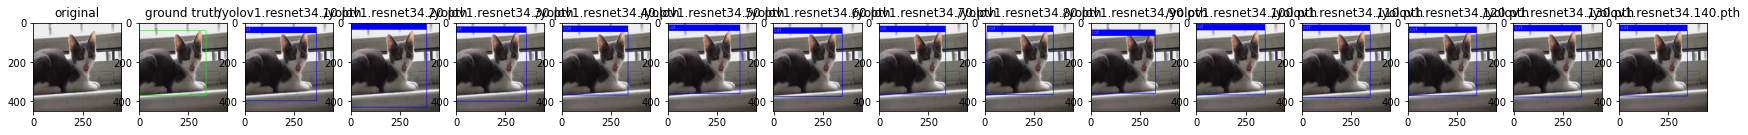

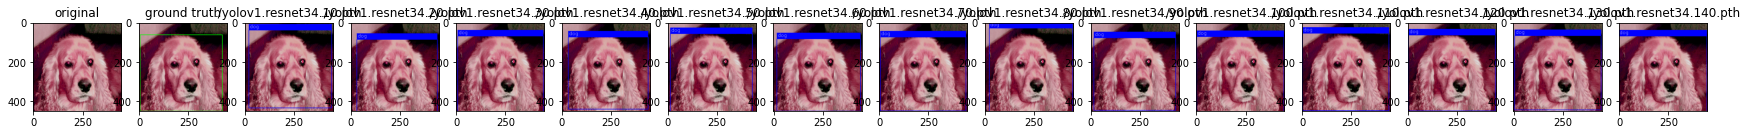

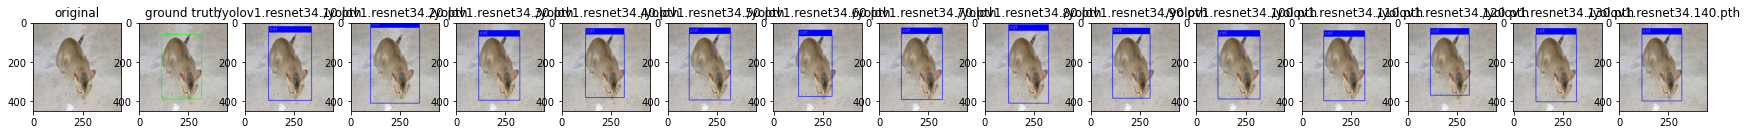

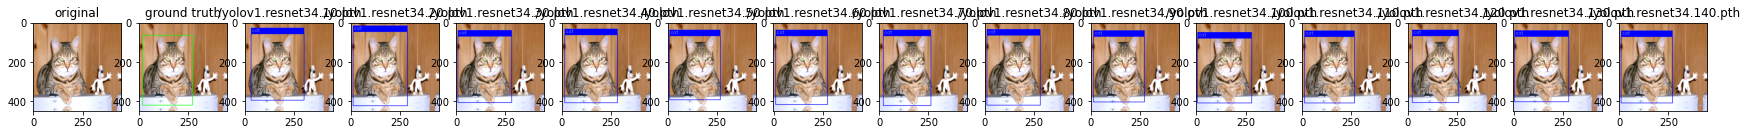

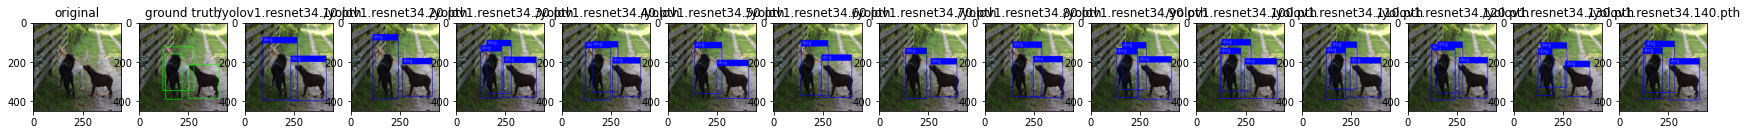

In [34]:
lots_of_prediction_and_lots_of_model(np.random.randint(low=0,high=len(trainset),size=5),
                                     [f'./yolov1.{MODEL_BACKBONE}.{(i+1)*10}.pth' for i in range(0,15)])

# evaluation

In [59]:
testimg, labels = trainset[110]

a = time.time()
testimgpred = model_predict(testimg)
b = time.time()
bbox_result = yolov1_decode(testimgpred, (IMAGE_SIZE,IMAGE_SIZE), len(voc_classes), 1)
c = time.time()
for class_idx in range(len(voc_classes)):
    best_index = nms(bbox_result[0,:,:4],bbox_result[0,:,4]*bbox_result[0,:,5+class_idx], nms_thres, conf_thres)
#     print(class_idx, len(best_index))
d = time.time()

print('inference time: ', b-a)
print('decode time: ', c-b)
print('nms time: ', d-c)

inference time:  0.02896857261657715
decode time:  0.0010001659393310547
nms time:  0.019002437591552734


In [35]:
def map_table(prediction: torch.Tensor, groundtruth: torch.Tensor, in_format: str = 'xywh') -> torch.Tensor:
    """produce iou and prob and gt num"""
    
    assert prediction.dim() == 2, 'the pred should be [N,4]'
    assert groundtruth.dim() == 2, 'the gt should be [M,4]'
    
    assert prediction.shape[1] == 5, 'coord 4 and prob 1'
    assert groundtruth.shape[1] == 4, 'coord 4'
    
    score = prediction[:,4] # ?
    
    if in_format == 'xywh':
        prediction = torchvision.ops.box_convert(prediction[:,:4],'xywh','xyxy')
        groundtruth = torchvision.ops.box_convert(groundtruth,'xywh','xyxy')
        
    # if many prediction overlapped with a ground truth, then best prediction left
    # if many groundtruth overlapped with a prediction, not matter
    
    ious = torchvision.ops.box_iou(prediction, groundtruth)
    iou_list, gt_index = ious.max(dim=1)
    iou_sort, iou_sort_index = iou_list.sort(descending=True)
    score = score[iou_sort_index]
    gt_index = gt_index[iou_sort_index]
    
    for i, ii in enumerate(gt_index):
        iou_sort[i+1:][gt_index[i+1:]==ii] = 0
        
    return iou_sort, score, groundtruth.size(0) # ? # ? # int

In [36]:
def mean_average_precision(table: List[tuple], iou_thres: float = 0.5) -> Tuple[List[float], List[float], float]:
    """for single class not the whole dataset"""
        
    total_gt_num = sum(gt_num for _, _, gt_num in table)
    
    ious = torch.cat([iou for iou, _, _ in table if iou is not None],0)
        
    prob = torch.cat([prob for _, prob, _ in table if prob is not None],0)  
    
    _, prob_index = prob.sort(descending=True)
    
    p = ious[prob_index]
    
    tp = p.gt(iou_thres).cumsum(0)
    
    precision = tp/torch.arange(1, tp.size(0)+1)
    recall = tp/total_gt_num
        
    auc = torch.trapz(precision,recall).item()
    
    return precision, recall, auc
    

In [37]:
def evaluate():
    
    MAP = {c: 0 for c in voc_classes}
    MAP_TABLE = {c: [] for c in voc_classes}
    
    # go through the dataset, not wise for big dataset
    for index, (img, label) in enumerate(tqdm(testloader)):
        # label, c,x,y,w,h
        # decode, x,y,w,h,c
        label = torch.stack([criterion.build_target(g) for g in label],0).float()
        
        output = model_predict(img)
        
        # recover gt coord in xywh
        label[:,3:5] = label[:,3:5]*IMAGE_SIZE # return w,h
        grid_x, grid_y = generate_grid((7,7))
        label[:,1] = label[:,1]*IMAGE_SIZE+grid_x*64-label[:,3]/2 # return x1
        label[:,2] = label[:,2]*IMAGE_SIZE+grid_y*64-label[:,4]/2 # return y1
        
        batch_decoded_output = yolov1_decode(output, (IMAGE_SIZE,IMAGE_SIZE), len(voc_classes), 1) # B, 98, 25
#         batch_decoded_output = yolov1_decode(output, (1,1), len(voc_classes), 1)
        
        for i in range(img.size(0)):
            single_label = label[i] # 25, 7, 7
            single_label = single_label.view(25,-1).transpose(0,1) # 49, 25
            single_label = single_label[single_label[:,0]==1] # ?, 25
            label_count = single_label[:,5:].sum(0)
            
            decoded_output = batch_decoded_output[i] # 98, 25
            decoded_output[:,5:] = decoded_output[:,4:5]*decoded_output[:,5:]
            cls_index = decoded_output[:,5:].argmax(1)
            
            for c in range(len(voc_classes)):
                no_detection = True
                this_class_detection = decoded_output[cls_index.eq(c)]
                if this_class_detection.size(0) != 0: 
                    class_prob = this_class_detection[:,5+c]
                    best_index = nms(this_class_detection[:,:4], class_prob,
                                     nms_thres, conf_thres)
                    
                    # if detection
                    if len(best_index) != 0: 
                        no_detection = False
                        this_class_detection = this_class_detection[best_index,:] # ?,25
                        this_class_label = single_label[single_label[:,5+c]==1,1:5]
                        # no class
                        if this_class_label.size(0) == 0:
                            tmp_table = (torch.zeros(len(best_index)), class_prob[best_index], 0)
                        # have class 
                        else:
                            tmp_table = map_table(torch.cat([this_class_detection[:,:4],class_prob[best_index].reshape(-1,1)],1), this_class_label)
          
                        MAP_TABLE[voc_classes[c]].append(tmp_table) # tuple
            
                # no detection
                if no_detection:
                    # have class
                    if label_count[c]:
                        tmp_table = (None, None, label_count[c].item())
                        MAP_TABLE[voc_classes[c]].append(tmp_table)
                            
                # check gt_num is correct
#                 if c == 0 and label_count[c]!=0:
#                     assert label_count[c]==tmp_table[2], f'{index,i}'
                
                
    
    # calculate pr curve and auc
    for c in voc_classes:
        MAP[c] = mean_average_precision(MAP_TABLE[c])
           
    return MAP, MAP_TABLE

In [38]:
def all_pr_curve(p:torch.Tensor, r:torch.Tensor) -> Tuple[torch.Tensor,torch.Tensor]:
    interpolated_precision = [p.max()]
    recall = [0]
    for i in r:
        tmp_p = p[r.gt(i)]
        if tmp_p.size(0) != 0: 
            interpolated_precision.append(tmp_p.max())
            recall.append(i)
        
    return torch.Tensor(interpolated_precision), torch.Tensor(recall)

In [40]:
conf_thres = 0.3 # the lower, the more boxes
nms_thres = 0.5 # the higher, the more boxes

# all epoch evaluation

In [39]:
# all model search
result = {}
for m in [f'./yolov1.{MODEL_BACKBONE}.{(i+1)*10}.pth' for i in range(0,15)]:
    model.load_state_dict(torch.load(m))
    print(m)
    
    map_score, debug_map = evaluate()
    eval_table = pd.DataFrame(map_score,index=['precision','recall','AP@0.5'])    
    mAP = {c: 0 for c in voc_classes}
    for c in voc_classes:
        p, r = all_pr_curve(eval_table[c]['precision'], eval_table[c]['recall'])
        auc = torch.trapz(p,r).item()
        mAP[c] = auc
    result[m] = mAP

  0%|                                                                                          | 0/310 [00:00<?, ?it/s]

./yolov1.resnet34.10.pth


  0%|                                                                                          | 0/310 [00:00<?, ?it/s]

./yolov1.resnet34.20.pth


  0%|                                                                                          | 0/310 [00:00<?, ?it/s]

./yolov1.resnet34.30.pth


  0%|                                                                                          | 0/310 [00:00<?, ?it/s]

./yolov1.resnet34.40.pth


  0%|                                                                                          | 0/310 [00:00<?, ?it/s]

./yolov1.resnet34.50.pth


  0%|                                                                                          | 0/310 [00:00<?, ?it/s]

./yolov1.resnet34.60.pth


  0%|                                                                                          | 0/310 [00:00<?, ?it/s]

./yolov1.resnet34.70.pth


  0%|                                                                                          | 0/310 [00:00<?, ?it/s]

./yolov1.resnet34.80.pth


  0%|                                                                                          | 0/310 [00:00<?, ?it/s]

./yolov1.resnet34.90.pth


  0%|                                                                                          | 0/310 [00:00<?, ?it/s]

./yolov1.resnet34.100.pth


  0%|                                                                                          | 0/310 [00:00<?, ?it/s]

./yolov1.resnet34.110.pth


  0%|                                                                                          | 0/310 [00:00<?, ?it/s]

./yolov1.resnet34.120.pth


  0%|                                                                                          | 0/310 [00:00<?, ?it/s]

./yolov1.resnet34.130.pth


  0%|                                                                                          | 0/310 [00:00<?, ?it/s]

./yolov1.resnet34.140.pth


  0%|                                                                                          | 0/310 [00:00<?, ?it/s]

./yolov1.resnet34.150.pth


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [01:15<00:00,  4.09it/s]


In [ ]:
# hyperparameter search
# result = {}

# for ct, nt in product([0.1,0.3,0.5],[0.3,0.5,0.7,0.9]):
#     conf_thres = ct
#     nms_thres = nt
#     for m in [f'yolov1.resnet18.{(i+1)*10}.pth' for i in range(9,10)]:
#         model.load_state_dict(torch.load(m))
#         print(m,ct,nt)
#         map_score = evaluate()
#         eval_table = pd.DataFrame(map_score,index=['precision','recall','AP@0.5'])    
#         mAP = {c: 0 for c in voc_classes}
#         for c in voc_classes:
#             p, r = eleven_point_pr_curve(eval_table[c]['precision'], eval_table[c]['recall'])
#             auc = torch.trapz(p,r).item()
#             mAP[c] = auc
#         result[f'{m},c:{conf_thres},n:{nms_thres}'] = mAP

In [ ]:
# single model single parameter set
prefix = './'
result = {}
conf_thres = 0.3
nms_thres = 0.5
for m in [f'{prefix}yolov1.resnet18.{(i+1)*10}.pth' for i in range(0,1)]:
    model.load_state_dict(torch.load(m))
    print(m,conf_thres,nms_thres)
    map_score,  debug_map = evaluate()
    eval_table = pd.DataFrame(map_score,index=['precision','recall','AP@0.5'])    
    mAP = {c: 0 for c in voc_classes}
    for c in voc_classes:
        p, r = all_pr_curve(eval_table[c]['precision'], eval_table[c]['recall'])
        auc = torch.trapz(p,r).item()
        mAP[c] = auc
    result[f'{m},c:{conf_thres},n:{nms_thres}'] = mAP

In [40]:
cmap = [list(r.values())+[np.mean(list(r.values()))] for m,r in result.items()]
result_table = pd.DataFrame(cmap,columns=voc_classes+['all'],index=result.keys())
result_table

,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,...,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor,all
./yolov1.resnet34.10.pth,0.580140,0.482976,0.471913,0.264648,0.134306,0.525996,0.538267,0.692539,0.203428,0.285482,...,0.653278,0.638220,0.479552,0.390897,0.109785,0.388256,0.455860,0.611818,0.460187,0.437059
./yolov1.resnet34.20.pth,0.509209,0.487343,0.367037,0.169425,0.094090,0.502851,0.575585,0.623944,0.152597,0.323064,...,0.544256,0.589531,0.455126,0.466090,0.084363,0.349560,0.443871,0.473789,0.363792,0.400976
./yolov1.resnet34.30.pth,0.639031,0.592095,0.533869,0.403817,0.211021,0.654969,0.624102,0.749614,0.266734,0.562639,...,0.694043,0.713020,0.611443,0.544077,0.169971,0.500418,0.564144,0.684112,0.434897,0.529497
./yolov1.resnet34.40.pth,0.620970,0.644268,0.580299,0.403969,0.163467,0.632222,0.656998,0.775336,0.302536,0.563607,...,0.654231,0.696562,0.535537,0.569853,0.150577,0.531935,0.556332,0.716571,0.480585,0.534574
./yolov1.resnet34.50.pth,0.664626,0.591915,0.512665,0.475709,0.265861,0.550344,0.685807,0.762909,0.276452,0.542527,...,0.393214,0.725116,0.583509,0.586671,0.254787,0.540206,0.497896,0.734335,0.559363,0.533485
./yolov1.resnet34.60.pth,0.623649,0.685719,0.338809,0.153624,0.249951,0.589847,0.687561,0.740150,0.289526,0.258940,...,0.695407,0.673795,0.637759,0.550998,0.245283,0.468048,0.502930,0.668808,0.543223,0.504868
./yolov1.resnet34.70.pth,0.278189,0.483723,0.603856,0.459845,0.251882,0.670748,0.674256,0.727330,0.314834,0.545661,...,0.702442,0.711915,0.616117,0.580530,0.237405,0.536014,0.505727,0.702370,0.524465,0.530441
./yolov1.resnet34.80.pth,0.625881,0.605500,0.542349,0.348306,0.197002,0.635019,0.638583,0.580246,0.263559,0.574043,...,0.564639,0.695657,0.621626,0.554696,0.204419,0.514460,0.443421,0.626544,0.353939,0.503617
./yolov1.resnet34.90.pth,0.695059,0.628571,0.543967,0.458295,0.267499,0.671681,0.702680,0.721837,0.300986,0.597217,...,0.676209,0.697810,0.582865,0.578122,0.249047,0.483502,0.522524,0.718579,0.522053,0.554126
./yolov1.resnet34.100.pth,0.705578,0.626123,0.625965,0.448848,0.273386,0.613113,0.663963,0.806622,0.303214,0.601153,...,0.644597,0.722561,0.639331,0.597611,0.234695,0.607766,0.481452,0.693334,0.502604,0.568095


In [46]:
result_table.loc[f'./yolov1.{MODEL_BACKBONE}.90.pth']

aeroplane      0.617155
bicycle        0.544393
bird           0.482339
boat           0.373510
bottle         0.166296
bus            0.570264
car            0.630301
cat            0.706292
chair          0.258458
cow            0.508919
diningtable    0.392764
dog            0.654173
horse          0.665472
motorbike      0.532794
person         0.539717
pottedplant    0.164651
sheep          0.534111
sofa           0.413857
train          0.640030
tvmonitor      0.484069
all            0.493978
Name: ./yolov1.resnet18.90.pth, dtype: float64

In [41]:
result_table.to_csv('./eval.csv')

<AxesSubplot:>

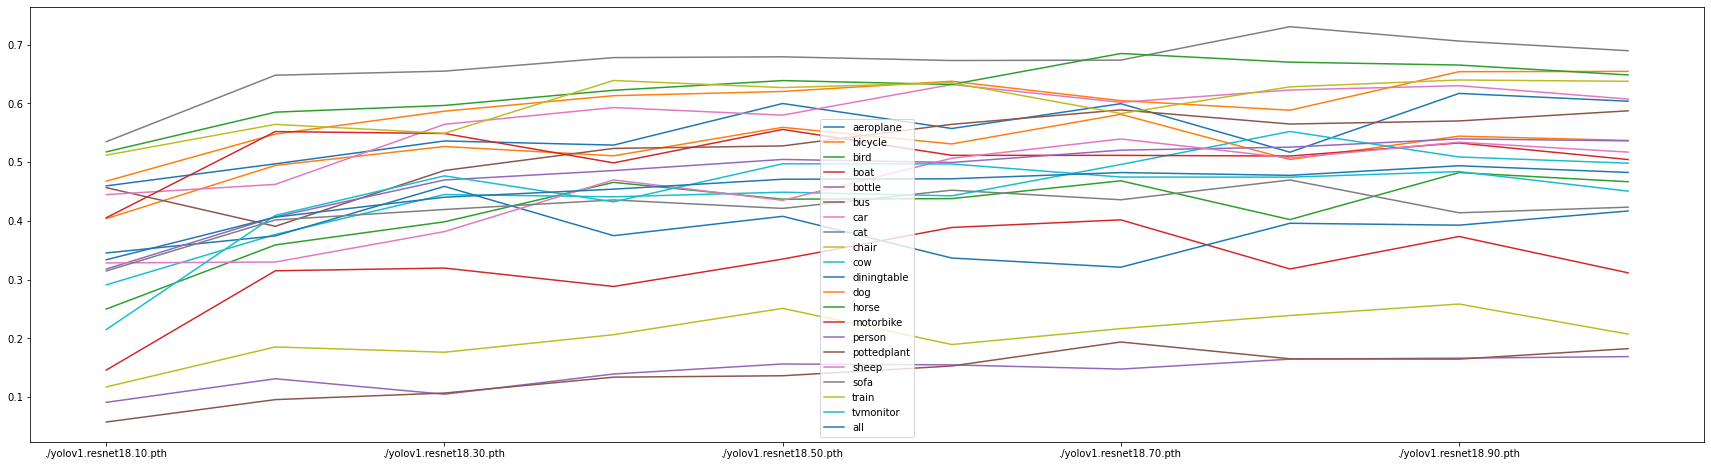

In [47]:
result_table.plot(figsize=(30,8))

<AxesSubplot:title={'center':'validation mAP on VOC 2007 test set'}>

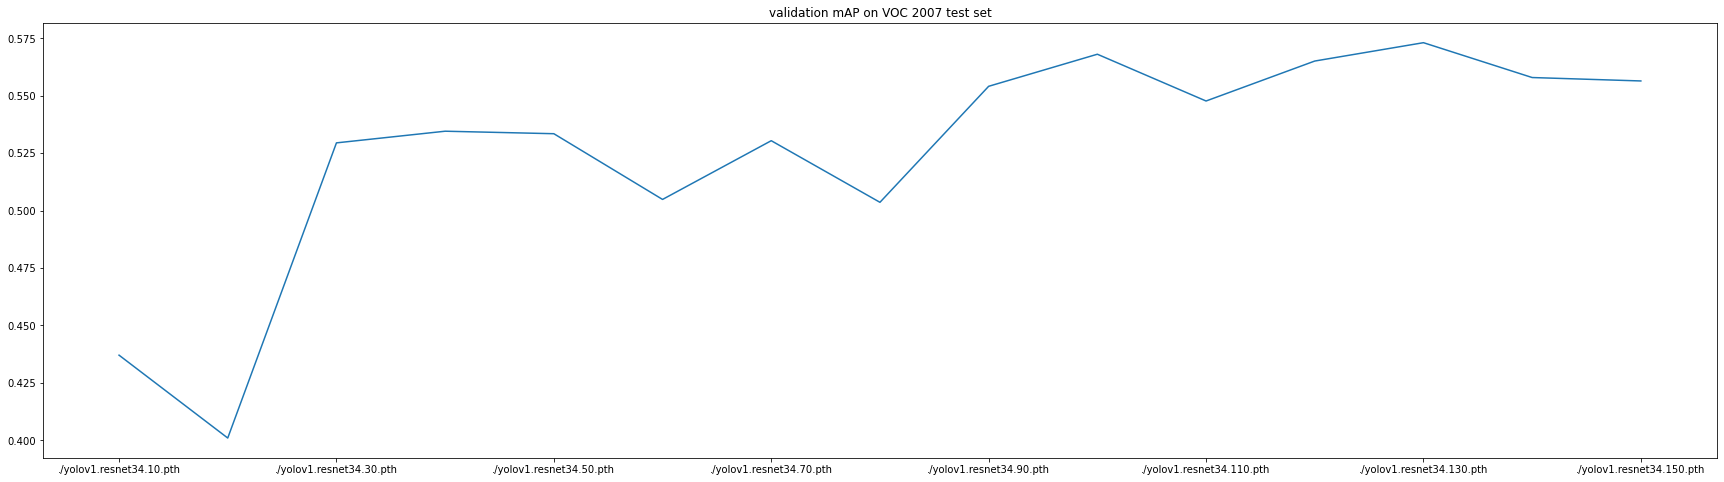

In [42]:
result_table['all'].plot(figsize=(30,8),title="validation mAP on VOC 2007 test set")

# debug

In [331]:
gt_num = 0
for _, label in tqdm(testloader):
    gt_num += label[:,5:,:,:].sum((0,2,3))

100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [00:29<00:00,  5.27it/s]


In [332]:
{c:g.item() for c, g in zip(voc_classes,gt_num)}

{'aeroplane': 265.0,
 'bicycle': 333.0,
 'bird': 450.0,
 'boat': 256.0,
 'bottle': 405.0,
 'bus': 212.0,
 'car': 1161.0,
 'cat': 358.0,
 'chair': 728.0,
 'cow': 238.0,
 'diningtable': 206.0,
 'dog': 488.0,
 'horse': 343.0,
 'motorbike': 317.0,
 'person': 4205.0,
 'pottedplant': 459.0,
 'sheep': 232.0,
 'sofa': 238.0,
 'train': 282.0,
 'tvmonitor': 305.0}

In [43]:
interest_cls = 'aeroplane'
Iamnotsure = pd.DataFrame({
    'iou': torch.cat([a for a, b, c in debug_map[interest_cls] if a is not None],0).numpy(),
    'prob': torch.cat([b for a, b, c in debug_map[interest_cls] if b is not None],0).numpy(),
    'gt': sum(c for a, b, c in debug_map[interest_cls])
}).sort_values('prob',ascending=False)
Iamnotsure['TP'] = Iamnotsure['iou'].gt(0.5).cumsum()
Iamnotsure['precision'] = Iamnotsure['TP']/np.arange(1,len(Iamnotsure)+1)
Iamnotsure['recall'] = Iamnotsure['TP']/Iamnotsure['gt']
Iamnotsure

,iou,prob,gt,TP,precision,recall
71,0.884566,0.890917,265.0,1,1.000000,0.003774
100,0.955297,0.890582,265.0,2,1.000000,0.007547
142,0.851079,0.879476,265.0,3,1.000000,0.011321
134,0.940841,0.871596,265.0,4,1.000000,0.015094
200,0.811990,0.857263,265.0,5,1.000000,0.018868
...,...,...,...,...,...,...
101,0.518033,0.335952,265.0,190,0.867580,0.716981
58,0.000000,0.321791,265.0,190,0.863636,0.716981
164,0.577316,0.320824,265.0,191,0.864253,0.720755
28,0.000000,0.319813,265.0,191,0.860360,0.720755


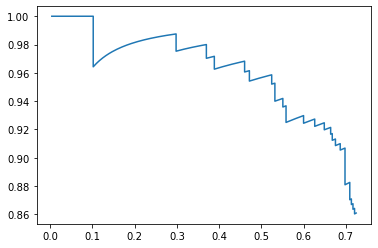

In [44]:
# plt.ylim(0,1.3)
plt.plot(Iamnotsure['recall'], Iamnotsure['precision'])

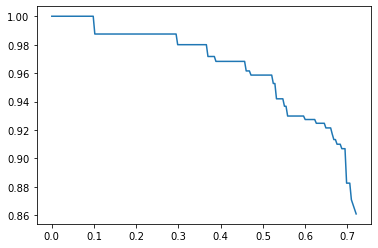

In [45]:
a,b = all_pr_curve(eval_table[interest_cls]['precision'],eval_table[interest_cls]['recall'])
plt.plot(b, a)

In [11]:
r18 = pd.read_csv('Final.1e-4/eval.csv',index_col=0)
r34 = pd.read_csv('Final.1e-4.34/eval.csv',index_col=0)

In [14]:
pd.concat([r18,r34]).loc[['./yolov1.resnet18.150.pth','./yolov1.resnet34.130.pth']].transpose()

,./yolov1.resnet18.150.pth,./yolov1.resnet34.130.pth
aeroplane,0.659695,0.699073
bicycle,0.601857,0.635265
bird,0.528688,0.610817
boat,0.457822,0.517191
bottle,0.199932,0.248924
bus,0.630690,0.716136
car,0.658628,0.670062
cat,0.751293,0.761671
chair,0.216588,0.309187
cow,0.550103,0.604650


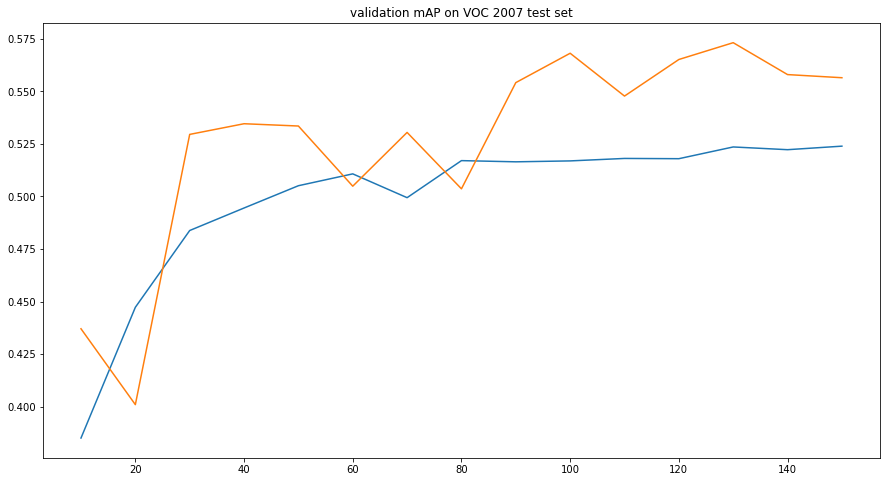

In [23]:
plt.figure(figsize=(15,8))
plt.title("validation mAP on VOC 2007 test set")
plt.plot(range(10,160,10), r18['all'])
plt.plot(range(10,160,10), r34['all'])